## CNN3

https://www.kaggle.com/behcetsenturk/finding-volcanoes-with-cnn

In [ ]:
Table of Contents:
I. Import Data 

## Import Data

In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
from random import shuffle
###------- Change directory
os.chdir('Volcano')



In [2]:
########---------------------------- load data
train_images = pd.read_csv('train_images.csv', sep=',', header=None)
test_images = pd.read_csv('test_images.csv', sep=',', header=None)
train_labels = pd.read_csv('train_labels.csv', sep=',')
test_labels = pd.read_csv('test_labels.csv', sep=',')

In [6]:
###------------------ concatenate data
all_images = pd.concat([train_images, test_images], axis=0)
all_labels = pd.concat([train_labels, test_labels], axis=0)

In [76]:
del train_images
del test_images
del train_labels
del test_labels

We're concatenating the training and testing data into one set so that in the future we may divide it up and perform a set of cross validated training and testing. 

### Show initial Data

In [7]:
all_images.head()

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115


In [8]:
all_images.shape

(9734, 12100)

There are 9,934 (110x110) images in this dataset. Each column j is the pixel index of row i and every entry is a value from 0-255 indicating the gray scaling of that pixel. 

### Show initial Labels

In [9]:
all_labels.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


'Volcano?' indicates whether the photo in each row image contains a volcano. This will be the column we are trying to predict in our classfier. 

### Concatenate Image/Labels

In [10]:
all_df = pd.concat([all_images, all_labels[['Volcano?']]], axis=1)
all_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano?
0,95,101,99,103,95,86,96,89,70,104,...,107,92,89,103,99,117,116,118,96,1
1,91,92,91,89,92,93,96,101,107,104,...,92,93,95,98,105,104,100,90,81,0
2,87,70,72,74,84,78,93,104,106,106,...,71,95,102,94,80,91,80,84,90,0
3,0,0,0,0,0,0,0,0,0,0,...,81,89,84,80,90,92,80,88,96,0
4,114,118,124,119,95,118,105,116,123,112,...,113,102,93,109,104,106,117,111,115,0


### Lets plot some volcanoes, quickly

#### randomly shuffle indices

In [11]:
def volcano_plotter(df, volcano=True, rows=5, columns=5):
    #df = dataframe.reset_index(drop=True)
    """
    Input: dataframe, whether we want to look at volcano labelled, Columns, Rows
    Output: Row x Column set of plots
    """
    
    cols=columns
    rows=rows
    fig=plt.figure(figsize=(13,13))
    shuffle_list = list(np.linspace(0,df.shape[0]-1, df.shape[0]))
    shuffle(shuffle_list)
    for i in range(1, rows*cols+1):
        if volcano==True:
            row = np.array(df[df['Volcano?']==1].iloc[i, :-1])
            image = row.reshape((110,110))
            fig.add_subplot(rows, cols, i)            
            #plt.figure()
            plt.imshow(image,cmap="Purples_r")
            plt.title('Volcano')

        else:
            row = np.array(df[df['Volcano?']==0].iloc[i, :-1])
            image = row.reshape((110,110))
            fig.add_subplot(rows, cols, i)
            #plt.figure()
            plt.imshow(image,cmap="Purples_r")
            plt.title('No Volcano')

            
    plt.tight_layout()
    plt.show()

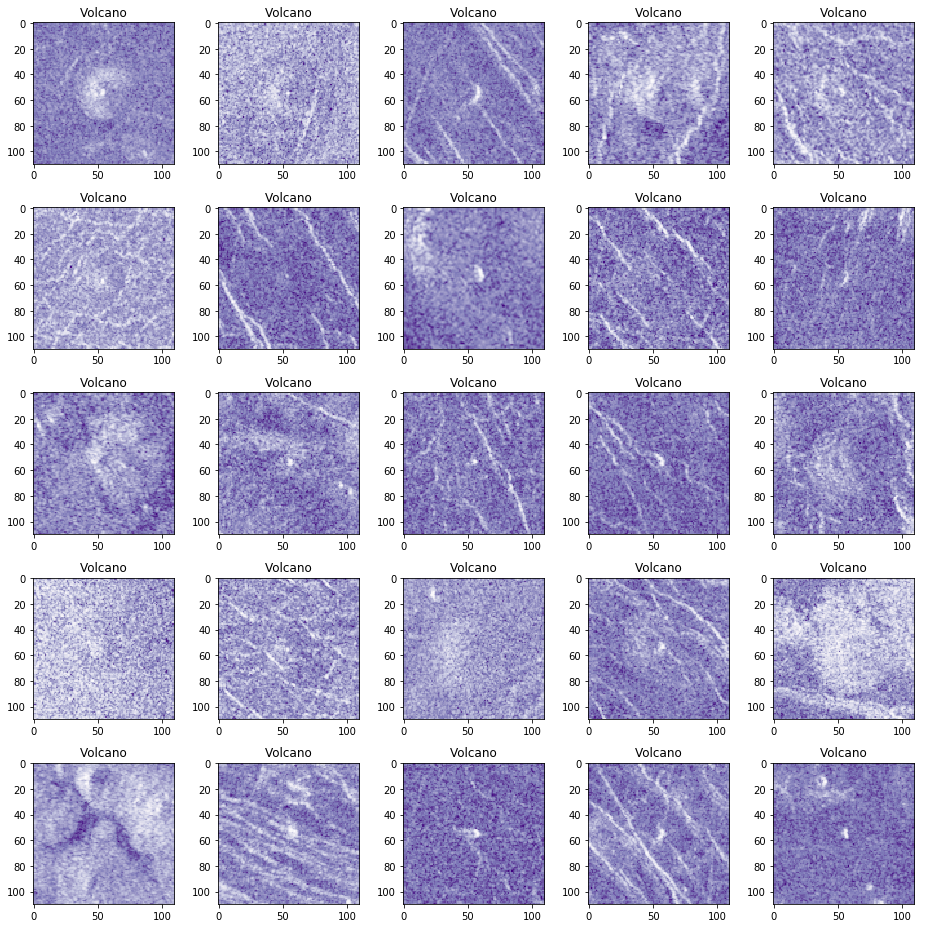

In [14]:
### Let's see what 100 volcanoes looks like
volcano_plotter(all_df, volcano=True, columns=5, rows=5)

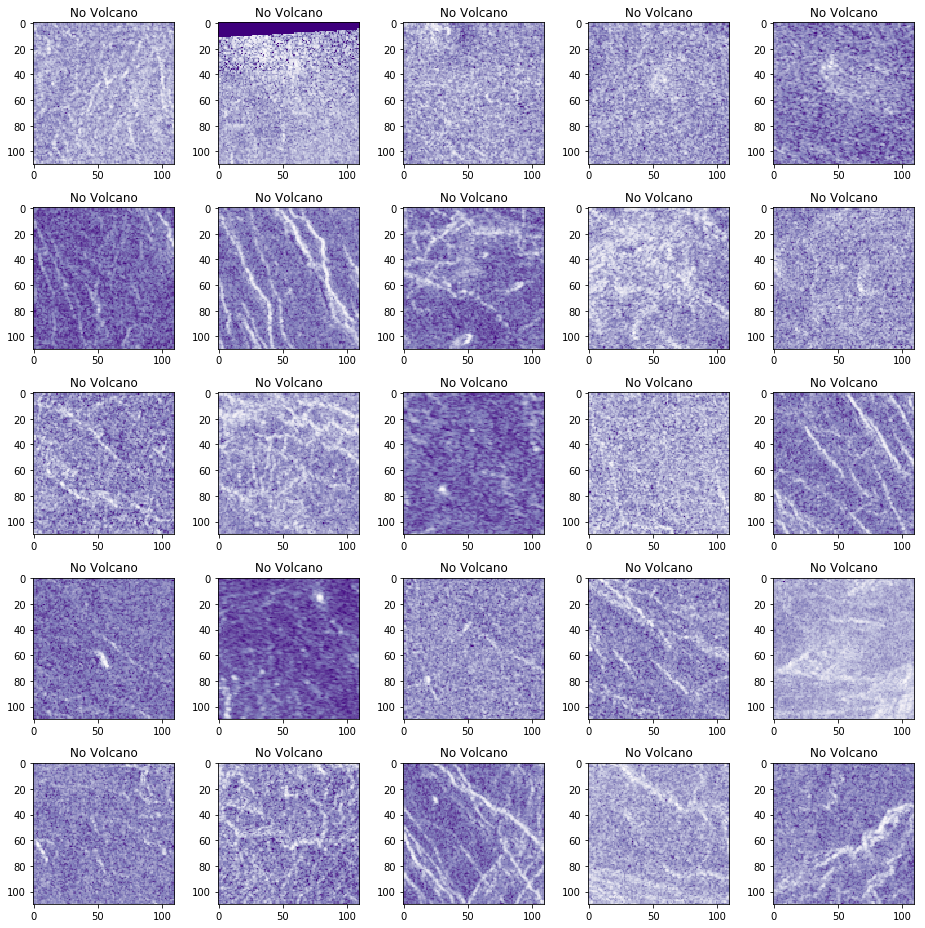

In [15]:
### Let's see what 100 non volcano images looks like
volcano_plotter(all_df, volcano=False, columns=5, rows=5)

Images that are labelled volcano have a clearly defined volcano-top within themn and a surrounding radius. Those that are not very clearly appear barren or have what appear to be rivers or valleys. 

In [17]:
### Overall we have 1,434 volacanoes
all_df[all_df['Volcano?']==1].shape[0]

1434

##### Plot the number of images labelled as Volcano/No Volcano

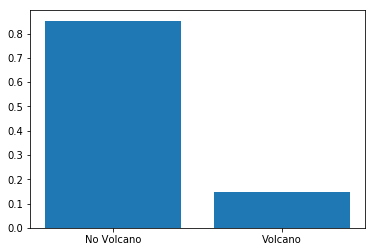

In [19]:
plt.bar(x=['Volcano', 'No Volcano'], height = [all_df[all_df['Volcano?']==1].shape[0]/all_df.shape[0], 
                                 all_df[all_df['Volcano?']==0].shape[0]/all_df.shape[0]])
#plt.xticks()
plt.title
plt.show()

There are 1,434 images with volcanoes, making up 14.73% of the dataset

## Removing Duplicate Items/Blanks

Lets see if there are any duplicates. Duplicates can severely bias a model if we do not remove them.

In [22]:
all_duplicated = all_df[all_df.duplicated(keep=False)== True]
all_duplicated = all_duplicated.sort_values(by=list(np.linspace(0,12099, 12100)))

In [23]:
all_duplicated.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano?
123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
all_duplicated.shape

(5387, 12101)

In [26]:
all_duplicated = all_duplicated.drop_duplicates(keep='first')
all_duplicated.shape

(1966, 12101)

The first few values appear to be all 0's which indicate corrupted images, others have black cutoffs like below. 
Overall, there are 1,966 duplicates totaling 5,387 rows.

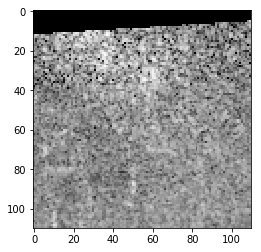

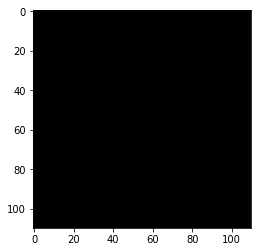

In [210]:
row = np.array(all_images.iloc[3])
image = row.reshape((110,110))
plt.figure()
plt.tight_layout()
plt.imshow(image,cmap="gray")




row = np.array(all_images.iloc[1271])
image = row.reshape((110,110))
plt.figure()
plt.tight_layout()
plt.imshow(image,cmap="gray")

Some of the images are unreadable and may bias our labeling and future models

In [83]:
del all_duplicated

### Lets drop duplicates

In [27]:
df_non_dup = all_df.drop_duplicates(keep='first')

In [28]:
df_non_dup.shape

(6313, 12101)

### Identify corrupted data
Now that we've dropped the duplicates, we want to go one step further and drop any of the images that have portions of them blacked out. 

In [29]:
def find_corrupted_image(row):
    """
    This function identifies 3 pixel indexes on the image (first, middle, 10th to last)
    and notes whether they have any black blotches on them
    Input: row
    Output: A new row with a new column called 'Corruped?', 1 if there are any black blotches, 0 if there aren't
    """
    top_left = 0
    center = 55*110 + 55 - 1
    bottom_right = 12090
    
    top_left_sum = row[list(np.linspace(top_left, top_left+10-1, 10))].sum()
    center_sum = row[list(np.linspace(center, center+10-1, 10))].sum()
    bottom_right_sum = row[list(np.linspace(bottom_right, center+10-1, 10))].sum()
    
    if top_left_sum == 0 or center_sum == 0 or bottom_right_sum == 0:
        row['Corrupted?'] = 1
    else:
        row['Corrupted?'] = 0
        
    return row

In [30]:
### Apply this function accross ever row in the dataframe
df_non_dup = df_non_dup.apply(lambda x: find_corrupted_image(x), axis=1)
df_non_dup.head()

,0,1,2,3,4,5,6,7,8,9,...,12092,12093,12094,12095,12096,12097,12098,12099,Volcano?,Corrupted?
0,95,101,99,103,95,86,96,89,70,104,...,92,89,103,99,117,116,118,96,1,0
1,91,92,91,89,92,93,96,101,107,104,...,93,95,98,105,104,100,90,81,0,0
2,87,70,72,74,84,78,93,104,106,106,...,95,102,94,80,91,80,84,90,0,0
3,0,0,0,0,0,0,0,0,0,0,...,89,84,80,90,92,80,88,96,0,1
4,114,118,124,119,95,118,105,116,123,112,...,102,93,109,104,106,117,111,115,0,0


In [31]:
### Retain Non Corrupted Data For further analysis
df_non_corruped = df_non_dup[df_non_dup['Corrupted?']==0]

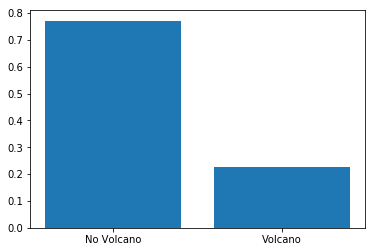

In [32]:
plt.bar(x=['Volcano', 'No Volcano'], height = [df_non_corruped[df_non_corruped['Volcano?']==1].shape[0]/df_non_corruped.shape[0], 
                                 df_non_corruped[df_non_corruped['Volcano?']==0].shape[0]/df_non_corruped.shape[0]])
#plt.xticks()
plt.title
plt.show()

In [33]:
df_non_corruped[df_non_corruped['Volcano?']==1].shape[0]/df_non_corruped.shape[0]

0.2283464566929134

The number of images with volcanoes have increased to almost 23% after dropping duplicates and removing corruped images.

## Split Data for Model  Insertion

In [35]:
### Shuffle Dataframe, remove 'Corrupted?' column
df_clean = df_non_corruped.sample(frac=1).reset_index(drop=True).iloc[:, :-1]
df_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano?
0,110,98,125,129,126,133,118,138,145,137,...,130,136,125,128,124,115,125,132,118,0
1,82,82,97,93,82,92,74,75,79,75,...,88,77,78,85,89,82,85,96,98,1
2,99,91,96,95,106,105,107,97,111,101,...,93,99,102,106,110,111,96,71,84,0
3,139,139,124,118,109,124,137,132,113,118,...,111,103,107,109,122,115,118,122,123,0
4,108,108,105,107,118,135,134,126,115,119,...,121,132,140,133,134,117,118,125,114,1


### Split data into 4 cross validation sets

In [36]:
cv_image_set1 = np.array_split(df_clean, 4)[0].iloc[:, :-1]
cv_label_set1 = np.array_split(df_clean, 4)[0].iloc[:, -1]

cv_image_set2 = np.array_split(df_clean, 4)[1].iloc[:, :-1]
cv_label_set2 = np.array_split(df_clean, 4)[1].iloc[:, -1]

cv_image_set3 = np.array_split(df_clean, 4)[2].iloc[:, :-1]
cv_label_set3 = np.array_split(df_clean, 4)[2].iloc[:, -1]

cv_image_set4 = np.array_split(df_clean, 4)[3].iloc[:, :-1]
cv_label_set4 = np.array_split(df_clean, 4)[3].iloc[:, -1]

In [37]:
print(cv_image_set1.shape)
print(cv_image_set2.shape)
print(cv_image_set3.shape)
print(cv_image_set4.shape)

(1556, 12100)
(1556, 12100)
(1556, 12100)
(1555, 12100)


In [38]:
print(cv_label_set1.shape)
print(cv_label_set2.shape)
print(cv_label_set3.shape)
print(cv_label_set4.shape)

(1556,)
(1556,)
(1556,)
(1555,)


In [ ]:
import gc


## Test Train Split

In [57]:
# from sklearn.model_selection import train_test_split
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

In [39]:
cv_image_set1 = np.resize(cv_image_set1, (1556, 110, 110, 1))
cv_image_set2 = np.resize(cv_image_set2, (1556, 110, 110, 1))
cv_image_set3 = np.resize(cv_image_set3, (1556, 110, 110, 1))
cv_image_set4 = np.resize(cv_image_set4, (1555, 110, 110, 1))

In [40]:
cv_image_set1 = cv_image_set1/255.0
cv_image_set2 = cv_image_set2/255.0
cv_image_set3 = cv_image_set3/255.0
cv_image_set4 = cv_image_set4/255.0

## Train Adams model

In [41]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
cv_label_set1 = to_categorical(cv_label_set1, num_classes = 2)
cv_label_set2 = to_categorical(cv_label_set2, num_classes = 2)
cv_label_set3 = to_categorical(cv_label_set3, num_classes = 2)
cv_label_set4 = to_categorical(cv_label_set4, num_classes = 2)

Using TensorFlow backend.


#### Initialize Model

In [78]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam

modelA = Sequential()
modelA.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', input_shape = (110,110,1)))
modelA.add(MaxPool2D(pool_size=(2,2)))
modelA.add(Conv2D(filters = 16, kernel_size = (3,3), activation ='relu'))
modelA.add(MaxPool2D(pool_size=(2,2)))
modelA.add(Flatten())

#modelA.add(Dense(y_train.shape[1], activation = "sigmoid"))
modelA.add(Dense(2, activation = "sigmoid"))

In [79]:
modelA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 106, 106, 8)       208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 51, 51, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 20002     
Total params: 21,378
Trainable params: 21,378
Non-trainable params: 0
_________________________________________________________________


In [55]:
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train 1, 2, 3

In [80]:
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Combine sets 1, 2, 3
train_123 = np.concatenate([cv_image_set1, cv_image_set2, cv_image_set3], axis=0)
label_123 = np.concatenate([cv_label_set1, cv_label_set2, cv_label_set3], axis=0)
print('Sets 1, 2, 3 combined\n\n\n')


print('The input images have dimension' + str(train_123.shape))
print('The test labels have dimension' + str(label_123.shape))


### Train
moldelA_trained = modelA.fit(train_123, label_123, batch_size=64, epochs = 5) #validation_data=(X_val, y_val))
print('Training complete\n\n\n\n')
## Test on set 4
scoreA = modelA.evaluate(cv_image_set4, cv_label_set4)
print('Test Loss on set 4 = ', scoreA[0])
print('Test Accuracy on set 4 = ', scoreA[1])

MemoryError: 

## Train 1, 2, 4

In [64]:
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Combine sets 1, 2, 4
train_124 = np.concatenate([cv_image_set1, cv_image_set2, cv_image_set4], axis=0)
label_124 = np.concatenate([cv_label_set1, cv_label_set2, cv_label_set4], axis=0)
print('Sets 2, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_124.shape))
print('The test labels have dimension' + str(label_124.shape))


### Train on sets 1,2 4
moldelA_trained = modelA.fit(train_124, label_124, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 3
scoreA = modelA.evaluate(cv_image_set3, cv_label_set3)
print('Test Loss on set 3 = ', scoreA[0])
print('Test Accuracy on set 3 = ', scoreA[1])

Data combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1761 - acc: 0.9372
Epoch 2/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1670 - acc: 0.9402
Epoch 3/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1482 - acc: 0.9458
Epoch 4/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1388 - acc: 0.9509
Epoch 5/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1477 - acc: 0.9456
Training complete




1556/1556 [==============================] - 6s 4ms/step
Test Loss on set 3 =  0.18885421454140336
Test Accuracy on set 3 =  0.9447300771208226


## Train 1, 3, 4

In [65]:
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Combine sets 1, 3, 4
train_134 = np.concatenate([cv_image_set1, cv_image_set3, cv_image_set4], axis=0)
label_134 = np.concatenate([cv_label_set1, cv_label_set3, cv_label_set4], axis=0)
print('Sets 1, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_134.shape))
print('The test labels have dimension' + str(label_134.shape))


### Train on sets 1,2 4
moldelA_trained = modelA.fit(train_134, label_134, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 2
scoreA = modelA.evaluate(cv_image_set2, cv_label_set2)
print('Test Loss on set 2 = ', scoreA[0])
print('Test Accuracy on set 2 = ', scoreA[1])

Sets 1, 3, 4 combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 44s 9ms/step - loss: 0.1439 - acc: 0.9490
Epoch 2/5
4667/4667 [==============================] - 36s 8ms/step - loss: 0.1270 - acc: 0.9563
Epoch 3/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.1155 - acc: 0.9614
Epoch 4/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.1046 - acc: 0.9670
Epoch 5/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.0992 - acc: 0.9685
Training complete




1556/1556 [==============================] - 5s 3ms/step
Test Loss on set 2 =  0.10322061135100828
Test Accuracy on set 2 =  0.958868894907993


## Train 2, 3, 4

In [66]:
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Combine sets 2, 3, 4
train_234 = np.concatenate([cv_image_set2, cv_image_set3, cv_image_set4], axis=0)
label_234 = np.concatenate([cv_label_set2, cv_label_set3, cv_label_set4], axis=0)
print('Sets 2, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_234.shape))
print('The test labels have dimension' + str(label_234.shape))


### Train on sets 2,3, 4
moldelA_trained = modelA.fit(train_234, label_234, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 1
scoreA = modelA.evaluate(cv_image_set1, cv_label_set1)
print('Test Loss on set 1 = ', scoreA[0])
print('Test Accuracy on set 1 = ', scoreA[1])

Sets 2, 3, 4 combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 33s 7ms/step - loss: 0.1022 - acc: 0.9634
Epoch 2/5
4667/4667 [==============================] - 36s 8ms/step - loss: 0.0885 - acc: 0.9698
Epoch 3/5
4667/4667 [==============================] - 35s 7ms/step - loss: 0.0795 - acc: 0.9736
Epoch 4/5
4667/4667 [==============================] - 39s 8ms/step - loss: 0.0827 - acc: 0.9713
Epoch 5/5
4667/4667 [==============================] - 35s 7ms/step - loss: 0.0639 - acc: 0.9792
Training complete




1556/1556 [==============================] - 6s 4ms/step
Test Loss on set 1 =  0.10913599805384491
Test Accuracy on set 1 =  0.9582262209264663


## Train Stochastic Gradient Descent

## Train 1, 2, 3

In [63]:
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Combine sets 1, 2, 3
train_123 = np.concatenate([cv_image_set1, cv_image_set2, cv_image_set3], axis=0)
label_123 = np.concatenate([cv_label_set1, cv_label_set2, cv_label_set3], axis=0)
print('Sets 1, 2, 3 combined\n\n\n')


print('The input images have dimension' + str(train_123.shape))
print('The test labels have dimension' + str(label_123.shape))


### Train
moldelA_trained = modelA.fit(train_123, label_123, batch_size=64, epochs = 5) #validation_data=(X_val, y_val))
print('Training complete\n\n\n\n')
## Test on set 4
scoreA = modelA.evaluate(cv_image_set4, cv_label_set4)
print('Test Loss on set 4 = ', scoreA[0])
print('Test Accuracy on set 4 = ', scoreA[1])

The input images have dimension(4668, 110, 110, 1)
The test labels have dimension(4668, 2)
Epoch 1/5
4668/4668 [==============================] - 33s 7ms/step - loss: 0.1917 - acc: 0.9297
Epoch 2/5
4668/4668 [==============================] - 34s 7ms/step - loss: 0.1948 - acc: 0.9310
Epoch 3/5
4668/4668 [==============================] - 33s 7ms/step - loss: 0.1750 - acc: 0.9353
Epoch 4/5
4668/4668 [==============================] - 31s 7ms/step - loss: 0.1668 - acc: 0.9415
Epoch 5/5
1555/1555 [==============================] - 5s 3ms/step
Test Loss on set 4 =  0.2079160287497128
Test Accuracy on set 4 =  0.9254019295287669


## Train 1, 2, 4

In [64]:
## Combine sets 1, 2, 4
train_124 = np.concatenate([cv_image_set1, cv_image_set2, cv_image_set4], axis=0)
label_124 = np.concatenate([cv_label_set1, cv_label_set2, cv_label_set4], axis=0)
print('Sets 2, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_124.shape))
print('The test labels have dimension' + str(label_124.shape))


### Train on sets 1,2 4
moldelA_trained = modelA.fit(train_124, label_124, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 3
scoreA = modelA.evaluate(cv_image_set3, cv_label_set3)
print('Test Loss on set 3 = ', scoreA[0])
print('Test Accuracy on set 3 = ', scoreA[1])

Data combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1761 - acc: 0.9372
Epoch 2/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1670 - acc: 0.9402
Epoch 3/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1482 - acc: 0.9458
Epoch 4/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1388 - acc: 0.9509
Epoch 5/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1477 - acc: 0.9456
Training complete




1556/1556 [==============================] - 6s 4ms/step
Test Loss on set 3 =  0.18885421454140336
Test Accuracy on set 3 =  0.9447300771208226


## Train 1, 3, 4

In [65]:
## Combine sets 1, 3, 4
train_134 = np.concatenate([cv_image_set1, cv_image_set3, cv_image_set4], axis=0)
label_134 = np.concatenate([cv_label_set1, cv_label_set3, cv_label_set4], axis=0)
print('Sets 1, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_134.shape))
print('The test labels have dimension' + str(label_134.shape))


### Train on sets 1,2 4
moldelA_trained = modelA.fit(train_134, label_134, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 2
scoreA = modelA.evaluate(cv_image_set2, cv_label_set2)
print('Test Loss on set 2 = ', scoreA[0])
print('Test Accuracy on set 2 = ', scoreA[1])

Sets 1, 3, 4 combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 44s 9ms/step - loss: 0.1439 - acc: 0.9490
Epoch 2/5
4667/4667 [==============================] - 36s 8ms/step - loss: 0.1270 - acc: 0.9563
Epoch 3/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.1155 - acc: 0.9614
Epoch 4/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.1046 - acc: 0.9670
Epoch 5/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.0992 - acc: 0.9685
Training complete




1556/1556 [==============================] - 5s 3ms/step
Test Loss on set 2 =  0.10322061135100828
Test Accuracy on set 2 =  0.958868894907993


## Train 2, 3, 4

In [ ]:
## Combine sets 2, 3, 4
train_234 = np.concatenate([cv_image_set2, cv_image_set3, cv_image_set4], axis=0)
label_234 = np.concatenate([cv_label_set2, cv_label_set3, cv_label_set4], axis=0)
print('Sets 2, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_234.shape))
print('The test labels have dimension' + str(label_234.shape))


### Train on sets 2,3, 4
moldelA_trained = modelA.fit(train_234, label_234, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 1
scoreA = modelA.evaluate(cv_image_set1, cv_label_set1)
print('Test Loss on set 1 = ', scoreA[0])
print('Test Accuracy on set 1 = ', scoreA[1])

Sets 2, 3, 4 combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 33s 7ms/step - loss: 0.1022 - acc: 0.9634
Epoch 2/5
4667/4667 [==============================] - 36s 8ms/step - loss: 0.0885 - acc: 0.9698
Epoch 3/5
2816/4667 [=================>............] - ETA: 13s - loss: 0.0781 - acc: 0.9737

# Train Adadelta

## Train 1, 2, 3

In [63]:
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Combine sets 1, 2, 3
train_123 = np.concatenate([cv_image_set1, cv_image_set2, cv_image_set3], axis=0)
label_123 = np.concatenate([cv_label_set1, cv_label_set2, cv_label_set3], axis=0)
print('Sets 1, 2, 3 combined\n\n\n')


print('The input images have dimension' + str(train_123.shape))
print('The test labels have dimension' + str(label_123.shape))


### Train
moldelA_trained = modelA.fit(train_123, label_123, batch_size=64, epochs = 5) #validation_data=(X_val, y_val))
print('Training complete\n\n\n\n')
## Test on set 4
scoreA = modelA.evaluate(cv_image_set4, cv_label_set4)
print('Test Loss on set 4 = ', scoreA[0])
print('Test Accuracy on set 4 = ', scoreA[1])

The input images have dimension(4668, 110, 110, 1)
The test labels have dimension(4668, 2)
Epoch 1/5
4668/4668 [==============================] - 33s 7ms/step - loss: 0.1917 - acc: 0.9297
Epoch 2/5
4668/4668 [==============================] - 34s 7ms/step - loss: 0.1948 - acc: 0.9310
Epoch 3/5
4668/4668 [==============================] - 33s 7ms/step - loss: 0.1750 - acc: 0.9353
Epoch 4/5
4668/4668 [==============================] - 31s 7ms/step - loss: 0.1668 - acc: 0.9415
Epoch 5/5
1555/1555 [==============================] - 5s 3ms/step
Test Loss on set 4 =  0.2079160287497128
Test Accuracy on set 4 =  0.9254019295287669


## Train 1, 2, 4

In [64]:
## Combine sets 1, 2, 4
train_124 = np.concatenate([cv_image_set1, cv_image_set2, cv_image_set4], axis=0)
label_124 = np.concatenate([cv_label_set1, cv_label_set2, cv_label_set4], axis=0)
print('Sets 2, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_124.shape))
print('The test labels have dimension' + str(label_124.shape))


### Train on sets 1,2 4
moldelA_trained = modelA.fit(train_124, label_124, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 3
scoreA = modelA.evaluate(cv_image_set3, cv_label_set3)
print('Test Loss on set 3 = ', scoreA[0])
print('Test Accuracy on set 3 = ', scoreA[1])

Data combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1761 - acc: 0.9372
Epoch 2/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1670 - acc: 0.9402
Epoch 3/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1482 - acc: 0.9458
Epoch 4/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1388 - acc: 0.9509
Epoch 5/5
4667/4667 [==============================] - 34s 7ms/step - loss: 0.1477 - acc: 0.9456
Training complete




1556/1556 [==============================] - 6s 4ms/step
Test Loss on set 3 =  0.18885421454140336
Test Accuracy on set 3 =  0.9447300771208226


## Train 1, 3, 4

In [65]:
## Combine sets 1, 3, 4
train_134 = np.concatenate([cv_image_set1, cv_image_set3, cv_image_set4], axis=0)
label_134 = np.concatenate([cv_label_set1, cv_label_set3, cv_label_set4], axis=0)
print('Sets 1, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_134.shape))
print('The test labels have dimension' + str(label_134.shape))


### Train on sets 1,2 4
moldelA_trained = modelA.fit(train_134, label_134, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 2
scoreA = modelA.evaluate(cv_image_set2, cv_label_set2)
print('Test Loss on set 2 = ', scoreA[0])
print('Test Accuracy on set 2 = ', scoreA[1])

Sets 1, 3, 4 combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 44s 9ms/step - loss: 0.1439 - acc: 0.9490
Epoch 2/5
4667/4667 [==============================] - 36s 8ms/step - loss: 0.1270 - acc: 0.9563
Epoch 3/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.1155 - acc: 0.9614
Epoch 4/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.1046 - acc: 0.9670
Epoch 5/5
4667/4667 [==============================] - 32s 7ms/step - loss: 0.0992 - acc: 0.9685
Training complete




1556/1556 [==============================] - 5s 3ms/step
Test Loss on set 2 =  0.10322061135100828
Test Accuracy on set 2 =  0.958868894907993


## Train 2, 3, 4

In [ ]:
## Combine sets 2, 3, 4
train_234 = np.concatenate([cv_image_set2, cv_image_set3, cv_image_set4], axis=0)
label_234 = np.concatenate([cv_label_set2, cv_label_set3, cv_label_set4], axis=0)
print('Sets 2, 3, 4 combined\n\n\n')


print('The input images have dimension' + str(train_234.shape))
print('The test labels have dimension' + str(label_234.shape))


### Train on sets 2,3, 4
moldelA_trained = modelA.fit(train_234, label_234, batch_size=64, epochs = 5)
print('Training complete\n\n\n\n')

## Test on set 1
scoreA = modelA.evaluate(cv_image_set1, cv_label_set1)
print('Test Loss on set 1 = ', scoreA[0])
print('Test Accuracy on set 1 = ', scoreA[1])

Sets 2, 3, 4 combined



The input images have dimension(4667, 110, 110, 1)
The test labels have dimension(4667, 2)
Epoch 1/5
4667/4667 [==============================] - 33s 7ms/step - loss: 0.1022 - acc: 0.9634
Epoch 2/5
4667/4667 [==============================] - 36s 8ms/step - loss: 0.0885 - acc: 0.9698
Epoch 3/5
2816/4667 [=================>............] - ETA: 13s - loss: 0.0781 - acc: 0.9737